In [ ]:
!wget --header 'Host: storage.googleapis.com' --user-agent 'Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:87.0) Gecko/20100101 Firefox/87.0' --header 'Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,*/*;q=0.8' --header 'Accept-Language: en-US,en;q=0.5' --header 'Upgrade-Insecure-Requests: 1' 'https://storage.googleapis.com/kaggle-competitions-data/kaggle-v2/5144/862050/bundle/archive.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1619617655&Signature=PezX9IRS3G4eEr%2Bru%2FVFqF8YWY6B7Cvame5URZXK9Dh%2FhDMF%2BJo64P7PhVy1A8704x5TGHOB6ENC8ADti8cQbvlV6JwHZ1HGm2QNCkGrKW2dCIXiCVrSw%2BQCg9x%2B8RKIfXjCcgAFG7XQQI%2Fk2oN2r72dlvklz7dqOQjPlXt%2FSQPPy%2FpwIvYE1lkfNMnDgfBI6GwIht%2FeRygKpodh16RLyagIKTs0%2FzRfrEvlhUo4IsXCMYXstUfbrnN2dqtTwwjwogE1OFSfJP3bwjTNfmxNOkIY%2FVvzXmFDXgY3BahU7Y%2BNqJ0%2B7bdzNzVnRt99vj2sjPeeh2yvWJujgcdLl8UG3A%3D%3D&response-content-disposition=attachment%3B+filename%3Dultrasound-nerve-segmentation.zip' --output-document 'ultrasound-nerve-segmentation.zip'
!pip install q keras==2.4.1
!pip install segmentation_models
!pip install tensorflow_io
!unzip '/content/ultrasound-nerve-segmentation.zip'

In [2]:
#Loading dependancies
import os
import re
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import seaborn as sns
import cv2
from PIL import Image
from sklearn.model_selection import train_test_split, KFold
import tensorflow_io as tfio
import keras
import tensorflow as tf
# tf.compat.v1.enable_eager_execution()
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import UpSampling2D
from tensorflow.keras.layers import MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import concatenate,Dropout
from tensorflow.keras.layers import Multiply, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D
from tensorflow.keras.layers import BatchNormalization, Flatten, Conv2D, AveragePooling2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from keras.callbacks import ModelCheckpoint
import tensorflow
import keras
from sklearn.metrics import confusion_matrix
import cv2
import imgaug.augmenters as iaa
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
import segmentation_models as sm
from segmentation_models.metrics import iou_score
from segmentation_models import Unet
focal_loss = sm.losses.cce_dice_loss
import random
import segmentation_models as sm
from segmentation_models import Unet
# sm.set_framework('tf.keras')
tf.keras.backend.set_image_data_format('channels_last')

Using TensorFlow backend.


Segmentation Models: using `keras` framework.


In [7]:
#loading image df
img=pd.read_csv('/content/drive/MyDrive/dup_rem.csv')
df=pd.read_csv('/content/train_masks.csv')
img.drop('Unnamed: 0',axis=1,inplace=True)
img.image_name=img.image_name.astype(int)
img.subject_name=img.subject_name.astype(int)
img.columns=['image_path','img','subject','mask_path']
new_df=pd.merge(img,df,on=['img','subject'])
new_df.pixels.fillna(0,inplace=True)
val=[0 if i==0 else 1 for i in new_df.pixels]
new_df['mask_pres']=val

Loading model weights

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
#loading the classifier model
model_clf = keras.models.load_model('/content/drive/MyDrive/classfier_nerve')

In [5]:
#loading the segmentor model
model = keras.models.load_model('/content/drive/MyDrive/segmentor_nerve')

Train test split

In [8]:
X_train, X_valid, y_train, y_valid = train_test_split(new_df.image_path, new_df.mask_path, test_size=0.2, random_state=42)

In [9]:
def classifier_generator(images):
    '''Construct a data generator using tf.Dataset to load only images'''
    image_string=tf.io.read_file(images)
    image = tfio.experimental.image.decode_tiff(image_string)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, [128, 128])
    return image

In [10]:
def train_generator(images,masks):
    '''Construct a data generator using tf.Dataset to load image+masks'''
    image_string=tf.io.read_file(images)
    image = tfio.experimental.image.decode_tiff(image_string)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, [128, 128])
    mask=tf.io.read_file(masks)
    mask = tfio.experimental.image.decode_tiff(mask)
    mask = tf.image.convert_image_dtype(mask, tf.float32)
    mask = tf.image.resize(mask, [128, 128],method='nearest')
    return image,mask

In [11]:
def iou_coef(y_true, y_pred, smooth=1):
  '''This function calculates iou '''
  intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2])
  union = K.sum(y_true,[1,2])+K.sum(y_pred,[1,2])-intersection
  iou = K.mean((intersection + smooth) / (union + smooth))
  return iou.numpy()

In [12]:
def Heatmapgen(x):
  '''Prints the heatmap of correlation matrix'''
  group_names = ['True -ve','False +ve','False -ve','True +ve']
  group_counts = ['{0:0.0f}'.format(value) for value in x.flatten()]
  labels = [f'{v1}\n{v2}' for v1, v2 in
  zip(group_names,group_counts)]
  labels = np.asarray(labels).reshape(2,2)
  sns.heatmap(x, annot=labels, fmt='', cmap='RdBu')

Prediction

In [13]:
#Getting prediction out of the model
X_tr=np.zeros((len(X_train),128,128,4))
X_val=np.zeros((len(X_valid),128,128,4))
for i in range(len(X_train)):
  X_tr[i]=classifier_generator(X_train.iloc[i])
for i in range(len(X_valid)):
  X_val[i]=classifier_generator(X_valid.iloc[i])  
pred_clf_tr=model_clf.predict(X_tr)
pred_clf_val=model_clf.predict(X_val)

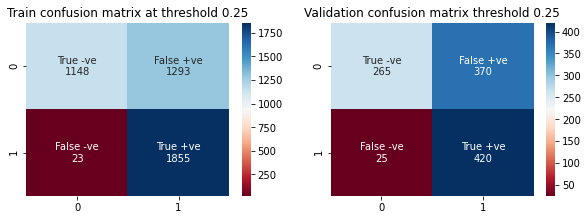

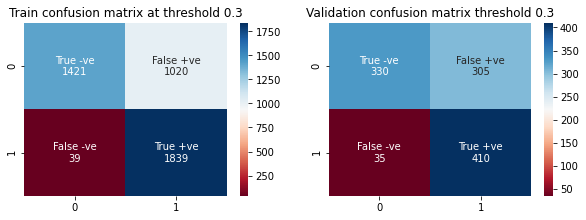

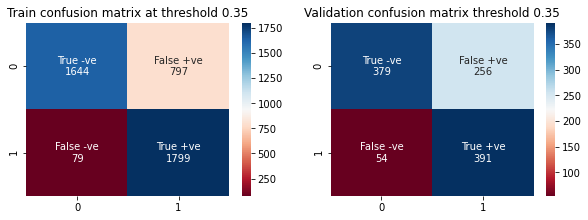

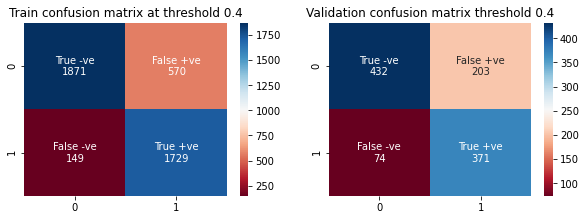

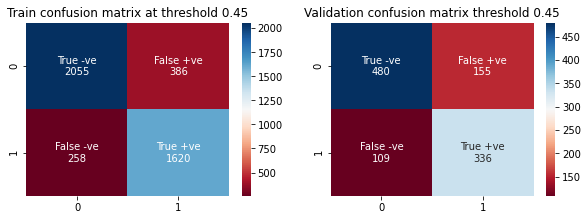

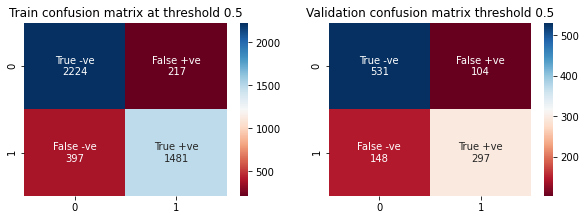

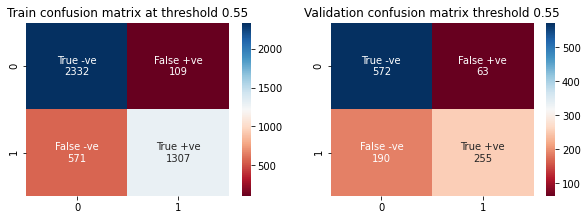

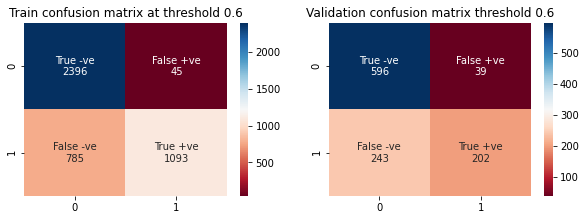

In [ ]:
#trying different thresholds
thresholds=[0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6]
for i in thresholds:
  pred_clf_val_=(np.array(pred_clf_val)>i)
  pred_clf_tr_=(np.array(pred_clf_tr)>i)
  fig = plt.figure(figsize=(10,7))
  ax1 = fig.add_subplot(221)
  cf_matr1=confusion_matrix(y_train,pred_clf_tr_)
  plt.title('Train confusion matrix at threshold {}'.format(i))
  Heatmapgen(cf_matr1)
  ax2 = fig.add_subplot(222)
  cf_matr2=confusion_matrix(y_valid,pred_clf_val_)
  plt.title('Validation confusion matrix threshold {}'.format(i))
  Heatmapgen(cf_matr2)

At threshold of 0.4 we see that false negative is less and false positives haven't increased too high..

In [ ]:
#Getting the prediction on train set
scores_tr=[]
X_tr=np.zeros((len(X_train),128,128,4),dtype=np.float32)
y_tr=np.zeros((len(y_train),128,128,4),dtype=np.float32)
for i in range(len(X_train)):
  image_cl=classifier_generator(X_train.iloc[i])
  image_cl=tf.expand_dims(image_cl,0)
  pred_clf=model_clf.predict(image_cl)
  if pred_clf>=0.4:
    X_tr[i],y_tr[i]=train_generator(X_train.iloc[i],y_train.iloc[i])
    pred_seg=model.predict(tf.expand_dims(X_tr[i],0))
    true=tf.expand_dims(y_tr[i],0)
    score=iou_coef(true,pred_seg)
    scores_tr.append(score)
  else:
    X_tr[i],y_tr[i]=train_generator(X_train.iloc[i],y_train.iloc[i])
    pred_seg=np.zeros((1,128,128,4),dtype=np.float32)
    true=tf.expand_dims(y_tr[i],0)
    score=iou_coef(true,pred_seg)
    scores_tr.append(score)

In [14]:
#Getting the prediction on validation set
scores_val=[]
X_tr=np.zeros((len(X_valid),128,128,4),dtype=np.float32)
y_tr=np.zeros((len(y_valid),128,128,4),dtype=np.float32)
pred_val=np.zeros((len(y_valid),128,128,4),dtype=np.float32)
for i in range(len(X_valid)):
  image_cl=classifier_generator(X_valid.iloc[i])
  image_cl=tf.expand_dims(image_cl,0)
  pred_clf=model_clf.predict(image_cl)
  if pred_clf>=0.4:
    X_tr[i],y_tr[i]=train_generator(X_valid.iloc[i],y_valid.iloc[i])
    pred_seg=model.predict(tf.expand_dims(X_tr[i],0))
    pred_val[i]=pred_seg
    true=tf.expand_dims(y_tr[i],0)
    score=iou_coef(true,pred_seg)
    scores_val.append(score)
  else:
    X_tr[i],y_tr[i]=train_generator(X_valid.iloc[i],y_valid.iloc[i])
    pred_seg=np.zeros((1,128,128,4),dtype=np.float32)
    pred_val[i]=pred_seg
    true=tf.expand_dims(y_tr[i],0)
    score=iou_coef(true,pred_seg)
    scores_val.append(score)

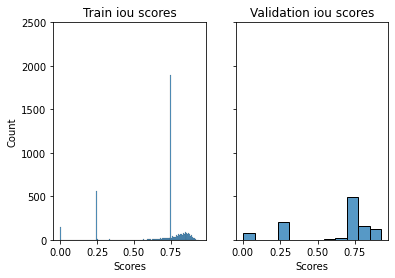

In [ ]:
#distribution of iou scores
import seaborn as sns
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True)
ax1.set_title('Train iou scores')
sns.histplot(scores_tr,ax=ax1)
ax1.set_xlabel('Scores')
ax2.set_title('Validation iou scores')
sns.histplot(scores_val,ax=ax2)
ax2.set_xlabel('Scores')
plt.ylim((0,2500))
plt.show()

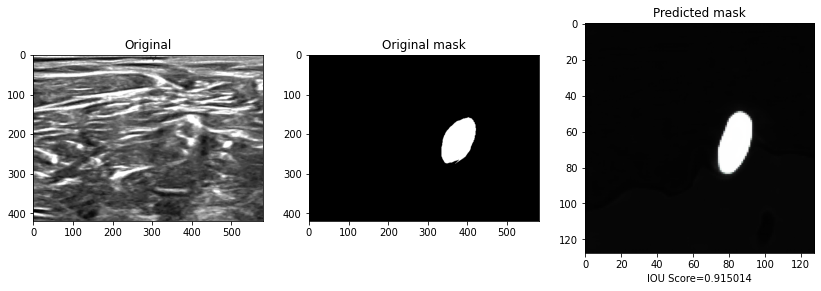

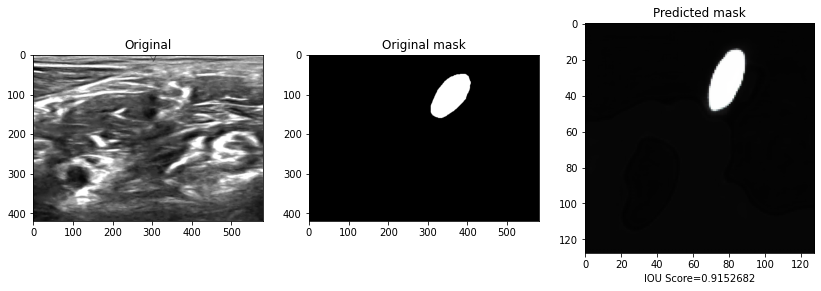

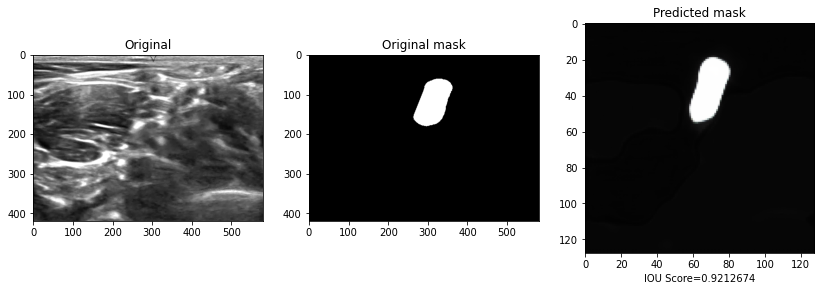

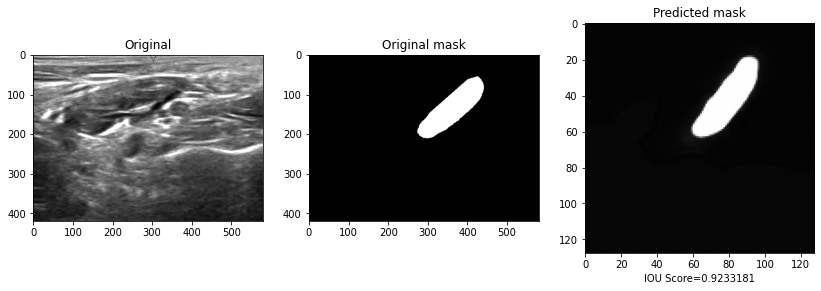

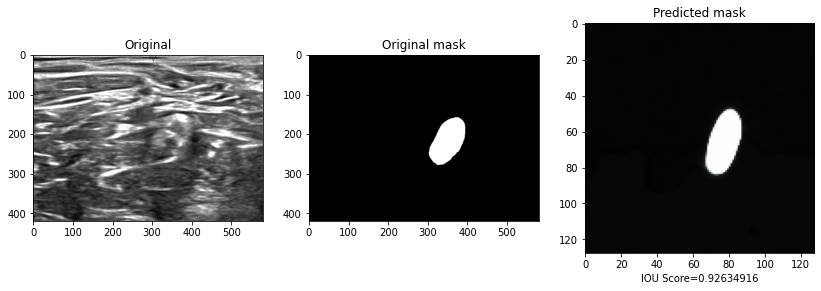

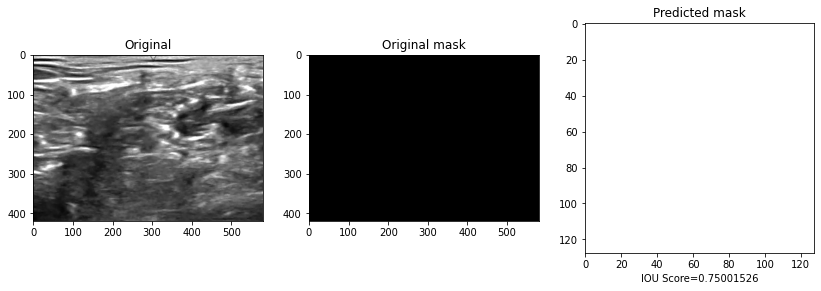

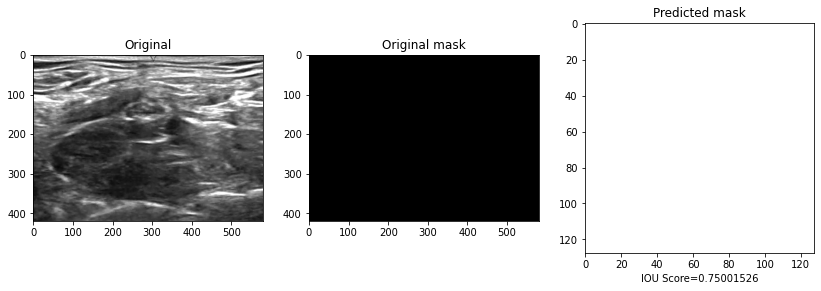

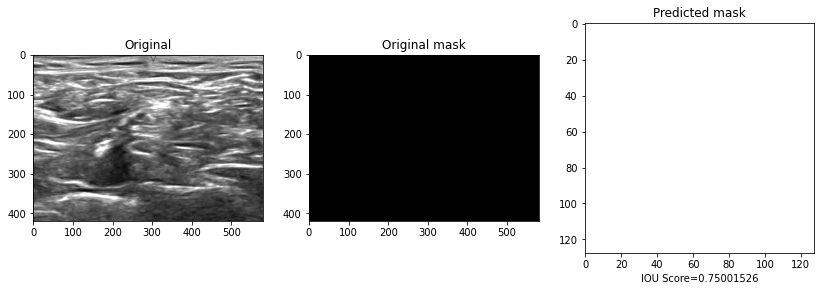

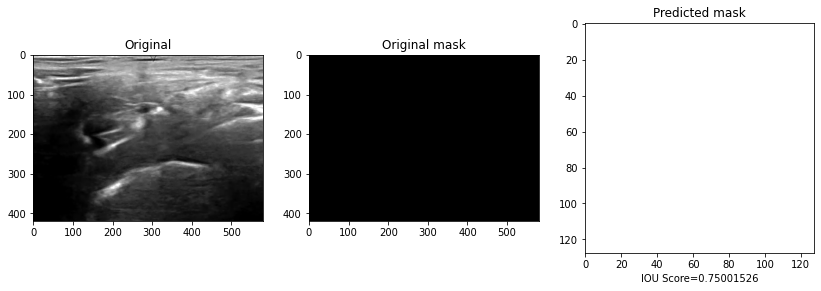

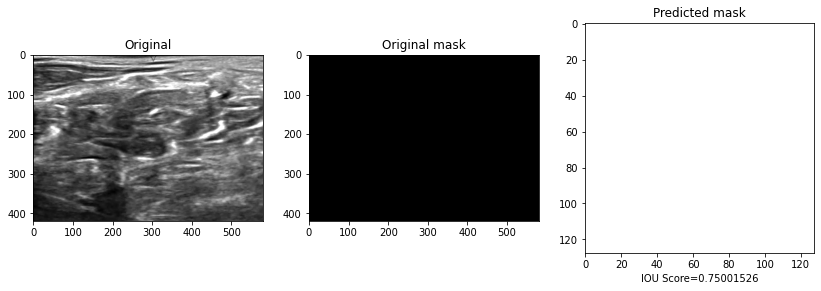

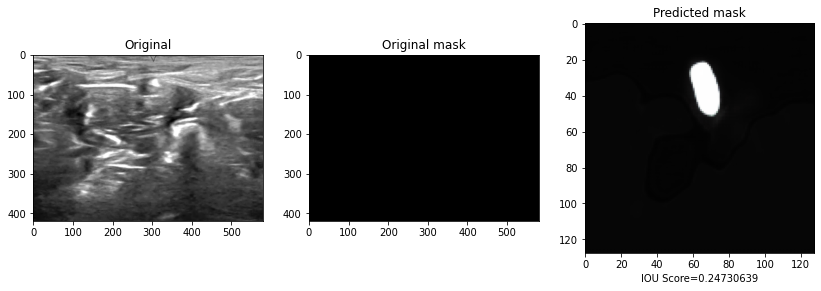

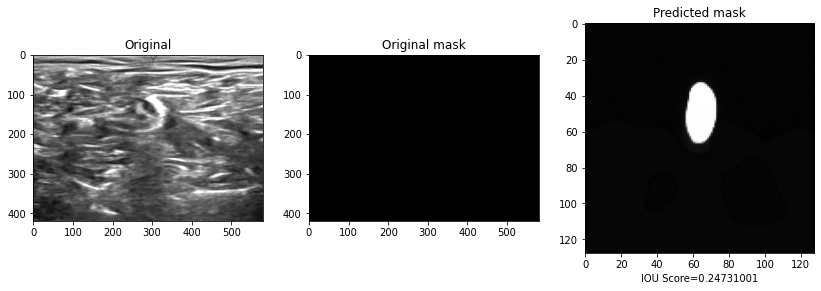

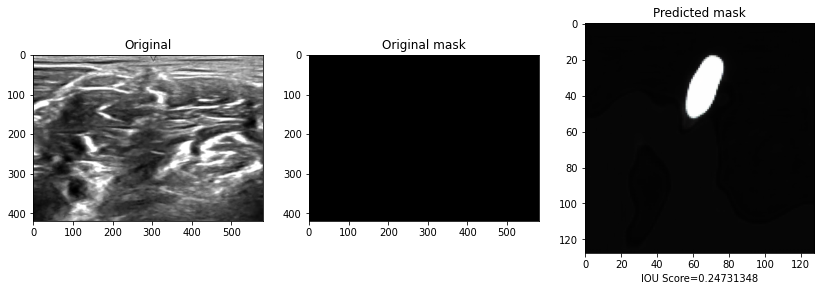

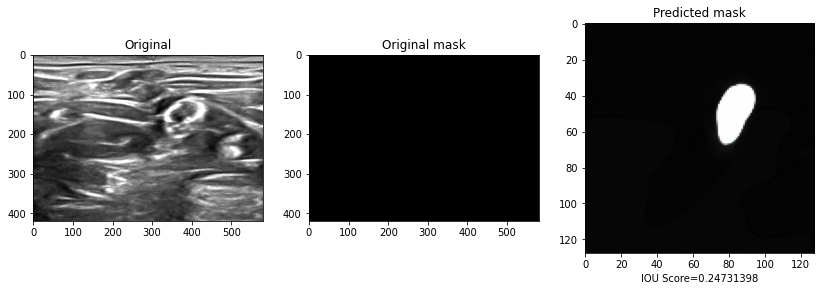

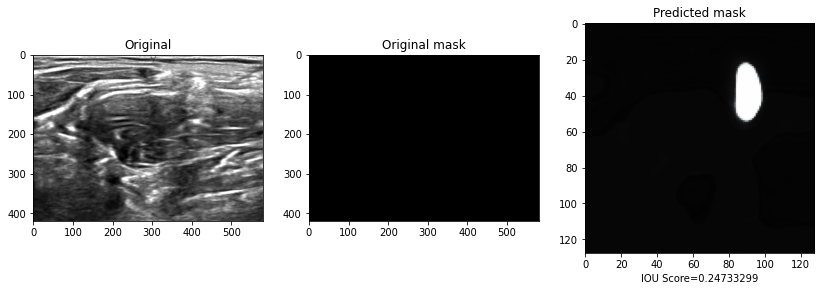

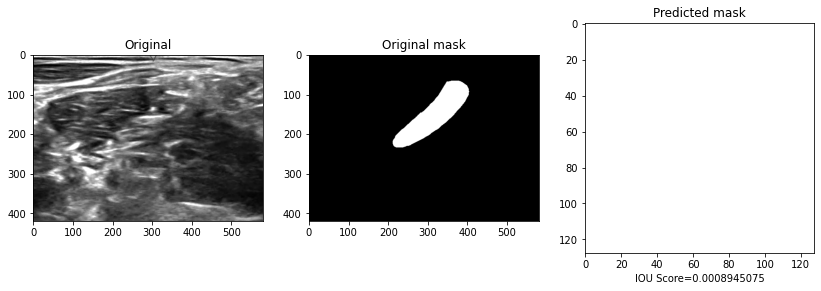

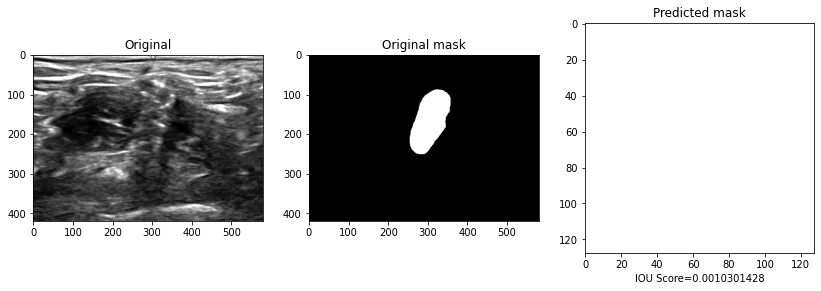

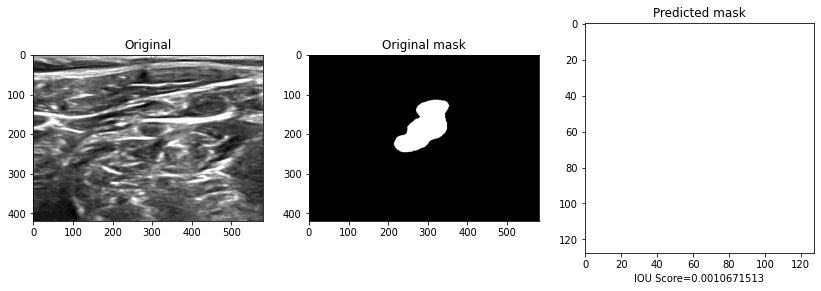

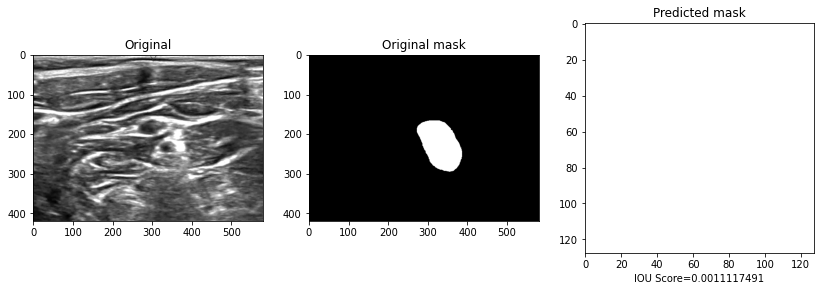

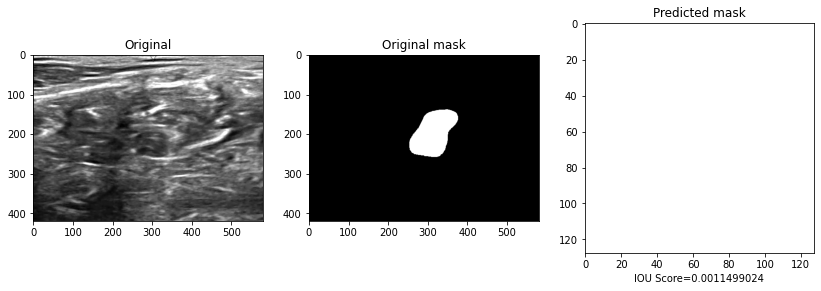

In [47]:
tp_pred=list(np.argsort(scores_val)[-5:])
fp_pred=list(np.argsort(scores_val)[210:215])
fn_pred=list(np.argsort(scores_val)[:5])
tn_pred=list(np.argsort(scores_val)[700:705])
ps_pred=tp_pred+tn_pred+fp_pred+fn_pred
for i in ps_pred:
  fig,ax=plt.subplots(1,3,figsize=(14,7))
  plt.xlabel('IOU Score='+str(scores_val[i]))
  quer=classifier_generator(X_valid.iloc[i])
  ax[0].imshow(cv2.imread(X_valid.iloc[i],cv2.IMREAD_GRAYSCALE),cmap='gray')
  ax[0].set_title('Original')
  ax[1].imshow(cv2.imread(y_valid.iloc[i],cv2.IMREAD_GRAYSCALE),cmap='gray')
  ax[1].set_title('Original mask')
  ax[2].imshow(pred_val[i])
  ax[2].set_title('Predicted mask')